### 9-bus test system
 Definition of the initial 9-bus test system (originally presented in Paul M. Anderson; A. A. Fouad, "Power System Control and Stability" , IEEE, 2003, pp.i-xiv, doi: 10.1109/9780470545577.fmatter.)

### First time this should be run in terminal: 
Install libraries (if  you use uv add dependencies are added to pyproject.toml automatically, if you use uv pip install you need to add manually)

In [ ]:
# Create venv
uv venv
# Activate it
.\.venv\Scripts\activate
# Install packages in the venv
uv add highspy pyscipopt matplotlib pandas numpy cartopy
uv add jupyter
uv add pypsa

Comments:
I ran this in Visual Studio code and had to make two changes to default set up:
1) (rookie mistake): I had all the repos in a one-drive folder, which caused some issues, so i moved everything to a folder not in one-drive
2) Visual studio code has powershell as default terminal (at least in my setup) which was not permitted to activate the vevn. Just changing to command prompt solved this...

### Importing and defining models

In [1]:
import pypsa
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


In [25]:
def create_9_bus_network(gen_bus1=1, gen_bus2=2,gen_bus3=3,plot=False):
    # Create network
    network = pypsa.Network()
    network.set_snapshots(range(1))
    #overwrite=overwrite
    # Set base MVA
    network.sbase = 100.0
    
    # Traditional IEEE 9-bus layout coordinates
    bus_coordinates = {
        1: (0, 0),      # default Generator 1 (slack)
        2: (4, 0),      # default Generator 2
        3: (2, 2),      # default Generator 3
        4: (1, -1),     # Load bus
        5: (3, -1),     # Load bus
        6: (2, 0.5),    # Load bus
        7: (1, 1),      # Load bus
        8: (3, 1),      # Load bus
        9: (2, -1)      # Load bus
    }
    
    # Add buses with coordinates    
    for i in range(1, 10):
        bus_data = {
            "x": bus_coordinates[i][0],
            "y": bus_coordinates[i][1],
            "v_nom": 22,
            "v_mag_pu_set": 1.0,
            "v_mag_pu_min": 0.9,
            "v_mag_pu_max": 1.1,
            "type": "Slack" if i == gen_bus1 else "PV" if i in [gen_bus2,gen_bus3] else "PQ" # setting controll type to decide which is the slack and which are the PV.
        }
        network.add("Bus", f"Bus {i}", **bus_data)
        
        # Add loads directly after creating each bus
        if i in [5, 7, 9]:
            load_p = {5: 90, 7: 100, 9: 125}[i]
            load_q = {5: 30, 7: 35, 9: 50}[i]
            network.add("Load", f"Load {i}", 
                    bus=f"Bus {i}",
                    p_set=load_p,
                    q_set=load_q)
        
    ## Add Generators
    gen_data = [
        {"bus": f"Bus {gen_bus1}", "p_nom": 250, "p_min_pu": 10/250, "p_set": 0},
        {"bus": f"Bus {gen_bus2}", "p_nom": 300, "p_min_pu": 10/300, "p_set": 163 },
        {"bus": f"Bus {gen_bus3}", "p_nom": 270, "p_min_pu": 10/270, "p_set": 85}
    ]
    
    for i, gen in enumerate(gen_data):
        network.add("Generator", f"Gen {i+1}", **gen)
    
    ## Add Lines
    branch_data = [
        [1, 4, 0, 0.0576, 0, 250],
        [4, 5, 0.017, 0.092, 0.158, 250],
        [5, 6, 0.039, 0.17, 0.358, 150],
        [3, 6, 0, 0.0586, 0, 300],
        [6, 7, 0.0119, 0.1008, 0.209, 150],
        [7, 8, 0.0085, 0.072, 0.149, 250],
        [8, 2, 0, 0.0625, 0, 250],
        [8, 9, 0.032, 0.161, 0.306, 250],
        [9, 4, 0.01, 0.085, 0.176, 250]
    ]
    
    for i, branch in enumerate(branch_data):
        f_bus, t_bus, r, x, b, rate = branch
        network.add("Line", f"Line {i+1}",
                   bus0=f"Bus {f_bus}",
                   bus1=f"Bus {t_bus}",
                   r=r,
                   x=x,
                   b=b,
                   s_nom=rate)
    
    if plot==True:
        plot_network()
    
    return network

In [27]:
def plot_network():
    plt.figure(figsize=(12, 8))
    # Plot base network
    n.plot(
        bus_sizes=0.01,          
        line_widths=2,          
        bus_colors='red',       
        line_colors='blue',     
        title="IEEE 9-bus System",
        margin=0.15,            
        geomap=False           
    )

    # Add bus labels and values
    for bus in n.buses.index:
        x = n.buses.x[bus]
        y = n.buses.y[bus]
        plt.annotate(
            f"{bus}",
            (x, y),
            xytext=(10, 10),
            textcoords='offset points'
        )

    # Add generator labels
    for gen in n.generators.index:
        bus = n.generators.bus[gen]
        x = n.buses.x[bus]
        y = n.buses.y[bus]
        plt.annotate(
            f"G: P={n.generators.p_nom[gen]}MW",
            (x, y),
            xytext=(-10, 20),
            textcoords='offset points',
            color='green'
        )

    # Add load labels
    for load in n.loads.index:
        bus = n.loads.bus[load]
        x = n.buses.x[bus]
        y = n.buses.y[bus]
        plt.annotate(
            f"L\nP={n.loads.p_set[load]}MW",
            (x, y),
            xytext=(10, -20),
            textcoords='offset points',
            color='brown'
        )

    plt.grid(True)
    plt.axis('equal')
    plt.show()

### Running power flow simulations


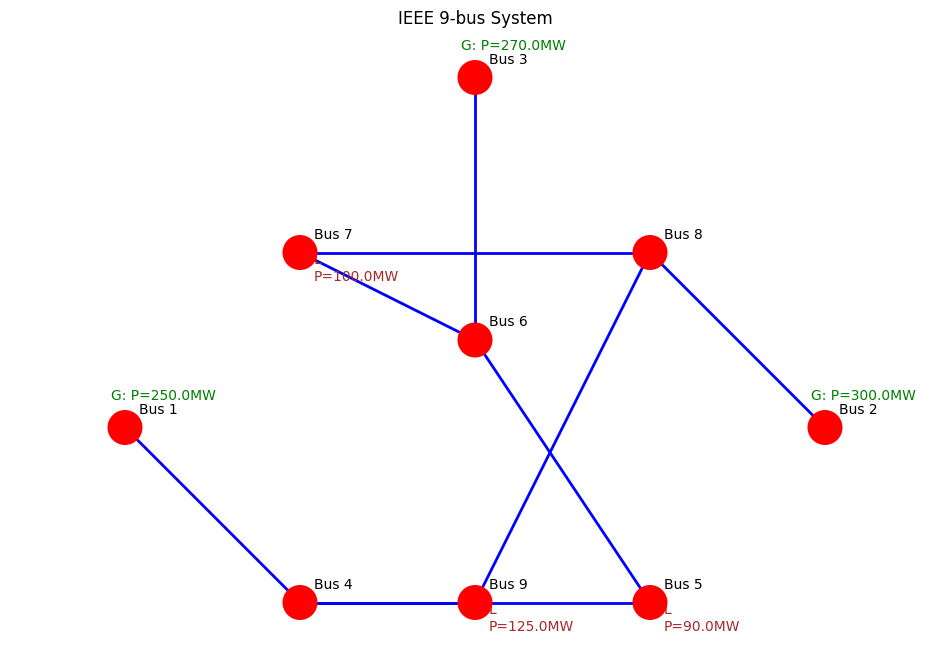

In [30]:
n = create_9_bus_network(gen_bus1=4, plot=True) # create the network with some parameters

In [29]:
n.pf()

INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots RangeIndex(start=0, stop=1, step=1, name='snapshot')


AttributeError: `np.Inf` was removed in the NumPy 2.0 release. Use `np.inf` instead.

In [16]:
n.pf() # run the power flow

INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots RangeIndex(start=0, stop=1, step=1, name='snapshot')


AttributeError: `np.Inf` was removed in the NumPy 2.0 release. Use `np.inf` instead.